# Quantum control via commutative pop optimization

In [1]:
import matplotlib.pyplot as plt

import numpy as np

from qutip import propagator, Qobj

from qcontrol_polyopt import CQCPolyOptDyson, CQCPolyOptMagnus

from sympy import I, diag, Float, symbols, lambdify, sympify

from sympy.matrices import randMatrix, matrix2numpy

# Constructing a quantum system

In [2]:
def get_random_matrix(n):
    """
    Generate random Hermitian matrix
    """
    H = randMatrix(4, percent=80) + I * randMatrix(4, percent=80)
    H = H.H + H
    
    return H / 200

In [3]:
# keep the field free Hamiltonian diagonal (it is better for sympy evaluation)
H0_random = diag(*sorted([Float(_) for _ in np.random.rand(4)]))
V_random = get_random_matrix(4)    

Generate random quantum system with the hamiltonian
$\hat{H}(t) = \hat{H}_0 + u(t) \hat{V}$,
where $u(t)$ is a control field.

In [4]:
qsys_params = dict(
    
    H0 = H0_random,
    V = V_random,
    
    # final time
    T = 1, 
    
    # polynomial order for the control
    npoly=6,
    
    min_module='both',
    #min_module='scipy',
    #min_module='ncpol2sdpa',
)

# convert sympy matrix to qutip objects for subsequent propagation 
H0 = Qobj(matrix2numpy(qsys_params['H0']))
V = Qobj(matrix2numpy(qsys_params['V']))

# Perform calculations

In [5]:
amplitudes = [0.1, 0.5, 2, 10,]

fidelity_dyson_scipy = []
fidelity_dyson_ncpol2sdpa = []

fidelity_magnus_scipy = []
fidelity_magnus_ncpol2sdpa = []


for ampl in amplitudes:
    # the chosen control
    u_original_str = '{} * sin(2 * 3.1416 * 20 * t)'.format(ampl)

    # get target unitary
    U_target = propagator([H0, [V, u_original_str]], qsys_params['T'])

    # covert the chosen control to the numpy function for plotting
    #t = symbols('t')
    #u_original = lambdify(t, sympify(u_original_str), 'numpy')
    
    dyson_result = CQCPolyOptDyson(U_target=U_target, **qsys_params)
    
    U_dyson = propagator([H0, [V, dyson_result.u_reconstructed['scipy'][0]]], dyson_result.T)
    fidelity_dyson_scipy.append(
        (U_dyson - U_target).norm()
    )
    print(fidelity_dyson_scipy[-1])
    
    U_dyson = propagator([H0, [V, dyson_result.u_reconstructed['ncpol2sdpa'][0]]], dyson_result.T)
    fidelity_dyson_ncpol2sdpa.append(
        (U_dyson - U_target).norm()
    )
    print(fidelity_dyson_ncpol2sdpa[-1])
    
    
    magnus_result = CQCPolyOptMagnus(U_target=U_target, **qsys_params)
    U_magnus = propagator([H0, [V, magnus_result.u_reconstructed['scipy'][0]]], magnus_result.T)
    fidelity_magnus_scipy.append(
        (U_magnus - U_target).norm()
    )
    print(fidelity_magnus_scipy[-1])
    
    U_magnus = propagator([H0, [V, magnus_result.u_reconstructed['ncpol2sdpa'][0]]], magnus_result.T)
    fidelity_magnus_ncpol2sdpa.append(
        (U_magnus - U_target).norm()
    )
    print(fidelity_magnus_ncpol2sdpa[-1])
    
    print(ampl)
    print("============================================================")
    

0.0005505596790944441
0.0005505596798367345
1.7703755318250374
1.7704005799849045
0.1
0.0027528756034618075
0.0027528756046939174
1.7703562758413471
1.7703650754189917
0.5
0.011010551189364276
0.011010551194320373
1.770290526035122
1.7703140233261445
2
0.05493353321203677
0.05493353325693019
1.7701290772238827
1.770144532833082
10


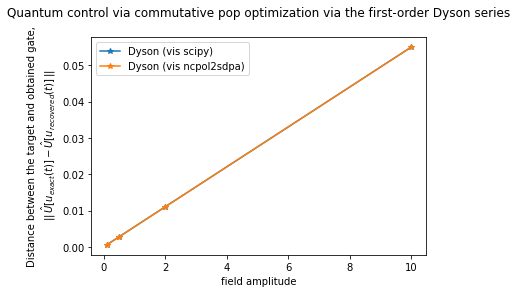

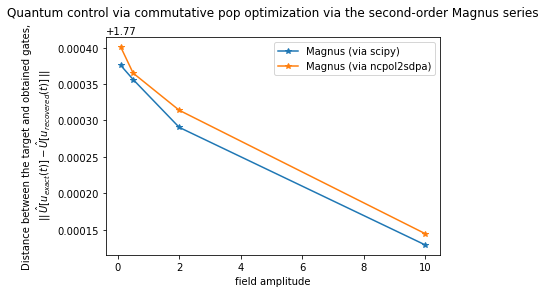

In [26]:
plt.title("Quantum control via commutative pop optimization via the first-order Dyson series\n")

plt.plot(amplitudes, fidelity_dyson_scipy, '*-', label='Dyson (vis scipy)')
plt.plot(amplitudes, fidelity_dyson_ncpol2sdpa, '*-', label='Dyson (vis ncpol2sdpa)')
plt.xlabel('field amplitude')
plt.ylabel('Distance between the target and obtained gate,\n $||\, \hat{U}[u_{exact}(t)] - \hat{U}[u_{recovered}(t)] \,||$')
plt.legend()
plt.show()

plt.title("Quantum control via commutative pop optimization via the second-order Magnus series\n")
plt.plot(amplitudes, fidelity_magnus_scipy, '*-', label='Magnus (via scipy)')
plt.plot(amplitudes, fidelity_magnus_ncpol2sdpa, '*-', label='Magnus (via ncpol2sdpa)')

plt.xlabel('field amplitude')
plt.ylabel('Distance between the target and obtained gates,\n $||\, \hat{U}[u_{exact}(t)] - \hat{U}[u_{recovered}(t)] \,||$')
plt.legend()
plt.show()